In [1]:
import numpy as np
import matplotlib.pyplot as plt
import functools
import operator
import math

gdk:  1000 (2, 2) 2 2


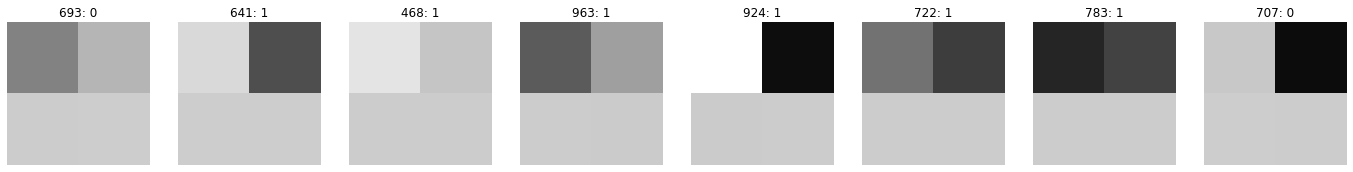

In [2]:
def show(data, labels=None, s=8):
    n, c, j = data.shape[0], data.shape[-1], 1
    labels = [None] * data.shape[0] if labels is None else labels
    plt.figure(figsize=(3 * (n if s == n else s), 3))
    for i in (range(n) if s == n else np.random.randint(0, n, s)):
        plt.subplot(1, s, j)
        plt.imshow(data[i], cmap="Greys", vmin=0, vmax=1)
        plt.title(str(i) + ": " + str(labels[i]))
        plt.axis("off")
        j += 1
    plt.show()

def gdk(n=1000, d=(2, 2), k=2, c=2, **kwargs):
    pd = functools.reduce(operator.mul, d, 1)
    assert(k <= pd)
    data = np.ones((n, *d))

    mask = np.arange(0, pd).reshape(d) < k
    common = np.ones((n, *d)) * 0.3
    random = np.random.random((n, *d))
    data = np.where(mask, random, common + 0.01 * random)
    labels = np.array([
        int((math.sin(d.flatten()[0] * 10) + 1) / 2 * c)
        for d in data])

    print("gdk: ", n, d, k, c)
    show(data, labels, **kwargs)
    return data, labels

gdk();

gdk:  8192 (2, 2) 2 2


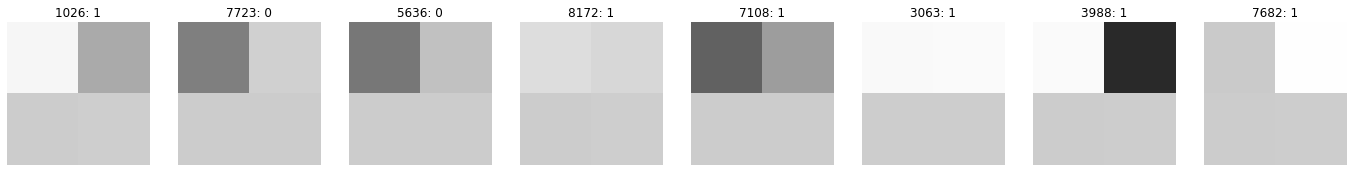

gdk:  1024 (2, 2) 2 2


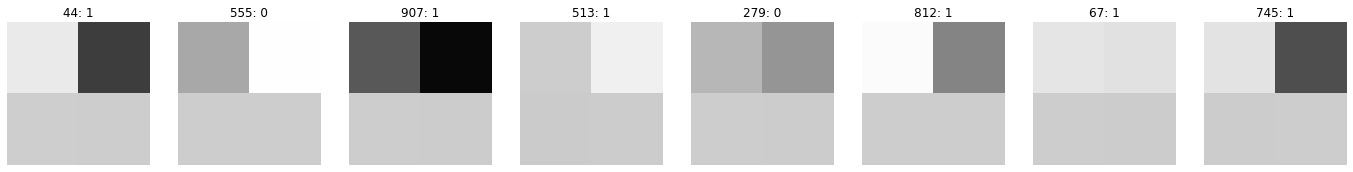

epoch 1 nerr 0.3720703125 loss 335.1069952430778
epoch 2 nerr 0.3720703125 loss 317.01212279554534
epoch 3 nerr 0.3720703125 loss 283.2885456720977
epoch 4 nerr 0.1708984375 loss 249.73691497314445
epoch 5 nerr 0.09765625 loss 220.83471701637083
epoch 6 nerr 0.0810546875 loss 199.6092412988577
epoch 7 nerr 0.0693359375 loss 182.20808465414768
epoch 8 nerr 0.0615234375 loss 169.1095385801844
epoch 9 nerr 0.056640625 loss 155.3313269675674
epoch 10 nerr 0.0556640625 loss 142.68220618361147
epoch 11 nerr 0.0546875 loss 131.29994871999256
epoch 12 nerr 0.052734375 loss 120.7631674323899
epoch 13 nerr 0.052734375 loss 111.43110811054108
epoch 14 nerr 0.052734375 loss 103.26082622856244
epoch 15 nerr 0.0419921875 loss 95.9990248658623
epoch 16 nerr 0.0361328125 loss 89.81225003120883
epoch 17 nerr 0.0322265625 loss 84.35582306818382
epoch 18 nerr 0.0244140625 loss 79.63396950653183
epoch 19 nerr 0.021484375 loss 75.50565764392715
epoch 20 nerr 0.01953125 loss 71.86686465341174
epoch 21 nerr 

In [3]:
import jax
from jax.experimental import stax, optimizers
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
key = jax.random.PRNGKey(0)

ns, d, k, c, batch = (8192, 1024), (2, 2), 2, 2, 512
init_fun, model = jax.experimental.stax.serial(
    jax.experimental.stax.Flatten,
    jax.experimental.stax.Dense(16),
    jax.experimental.stax.Relu,
    jax.experimental.stax.Dense(16),
    jax.experimental.stax.Relu,
    jax.experimental.stax.Dense(c),
    jax.experimental.stax.LogSoftmax)
_, params = init_fun(key, (batch, *d))
opt_init, opt_update, get_params = \
    jax.experimental.optimizers.adam(0.005)
opt_state = opt_init(params)

def meval(model, params, xs, ys):
    correct = 0
    for step in range(len(xs) // batch):
        x, y = xs[step * batch:(step + 1) * batch], \
            ys[step * batch:(step + 1) * batch]
        pred = np.argmax(model(params, x), axis=1)
        correct += np.sum(pred == y)
    return correct / len(xs)

trainx, trainy, testx, testy = \
    *gdk(ns[0], d, k, c), *gdk(ns[1], d, k, c)
for epoch in range(30):
    for step in range(ns[0] // batch):
        x, y = trainx[step * batch:(step + 1) * batch], \
            trainy[step * batch:(step + 1) * batch]
        loss, grads = jax.value_and_grad(
            lambda params, xs, ys: -np.sum(model(params, xs) *
            np.array([[1 if i == label else 0
                for i in range(c)]
                for label in ys])) # adaptor for softmax out
        )(params, x, y)
        opt_state = opt_update(0, grads, opt_state)
        params = get_params(opt_state)
    print("epoch", epoch + 1, "nerr", 1 - meval(model, params, testx, testy), "loss", loss)
print("nerrtrain", 1 - meval(model, params, trainx, trainy))
print("done")

In [4]:
import adversarial_ntks
from adversarial_ntks import attacks

def grad_f(X):
    grads = []
    for a in range(batch):
        def fun(XX):
            preds = model(params, XX.reshape((len(XX), *d)))
            predclass = jnp.argmax(preds[a])
            return preds[a][predclass]
        fungrad = jax.grad(fun)
        grads.append(fungrad(X))
    grads = jnp.sum(jnp.array(grads), axis=0)
    return grads

pertxs = []
for step in range(len(testx) // batch):
    x, y = testx[step * batch:(step + 1) * batch].reshape((batch, -1)), \
        testy[step * batch:(step + 1) * batch]
    pertx = adversarial_ntks.attacks.pgd(x, y,
        grad_f, 0.02, 2, 10, 0.003, 2, True).reshape((batch, *d))
    pred = np.argmax(model(params, x), axis=1)
    print(np.sum(pred == y))
    pred = np.argmax(model(params, pertx), axis=1)
    print(np.sum(pred == y))
    pertxs.append(pertx)

505
469
509
479


aerr 0.07421875


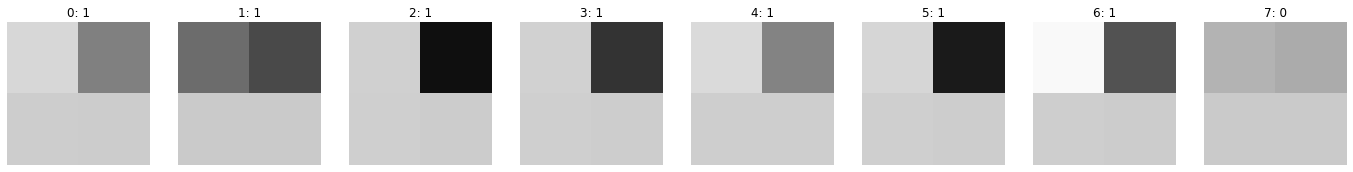

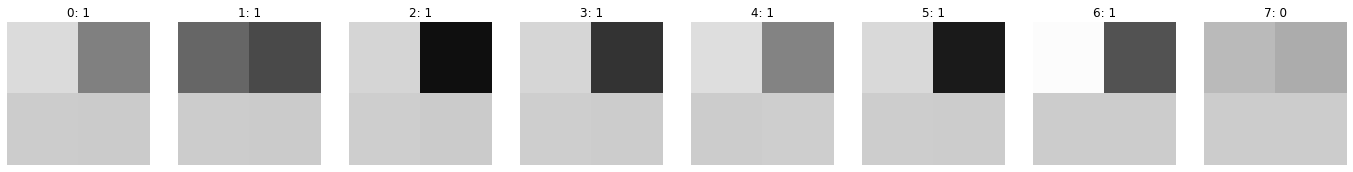

In [5]:
pertxs = np.array(pertxs).reshape((ns[1], *d))
print("aerr", 1 - meval(model, params, pertxs, testy))
show(pertxs[:8], testy, 8)
show(testx[:8], testy, 8)